In [ ]:
#Part 1 material
import os
from shapely.geometry import Point
import zipcode
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

In [3]:
#Part 2 material
import requests 
import requests_cache  
import pandas as pd
import numpy as np
from api_key import key  #API key for Walmart
import seaborn as sns
import plotly.plotly as py
from matplotlib import pyplot
requests_cache.install_cache('mycache') 

# Part 1: Walmart Geodata

In [4]:
#Walmart locations from an Excel file.
data = pd.read_excel('Walmart_Locations.xlsx',header = [0])
data = data[['City','Address','State','Zip']]
data_CA = data[data['State'].str.contains('CA') == True].reset_index()   #Only CA locations
data_zips = data_CA.Zip.astype(int).astype(str)                          #Change zipcodes to integers

In [5]:
#Get latitude and longitude Walmart locations into a Geodataframe.
def lat_lon():
    '''Get latitude and longitude Walmart locations into a Geodataframe from 
       the CSV file.
    
    Return(s): 
    gdf -- geodataframe with one column that has the POINT object for each location.
    '''
    lats = [zipcode.isequal(i).lat for i in data_zips]
    lons = [zipcode.isequal(i).lon for i in data_zips]

    latties = pd.DataFrame(np.array(lats).reshape(len(data_zips),1), columns = ['Lats'])
    lonnies = pd.DataFrame(np.array(lons).reshape(len(data_zips),1), columns = ['Lons'])
    geo_final = pd.concat([latties,lonnies],axis = 1)
    final_city = pd.concat([data_CA,geo_final],axis = 1)

    geometry = [Point(xy) for xy in zip(geo_final.Lons, geo_final.Lats)]
    geo_final = geo_final.drop(['Lons', 'Lats'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = GeoDataFrame(geo_final, crs=crs, geometry=geometry)
    return gdf
lat_lon().head(5)

,geometry
0,POINT (-115.6 32.77)
1,POINT (-118.48 34.72)
2,POINT (-118.86 35.2)
3,POINT (-117.36 34.48)
4,POINT (-118.83 35.43)


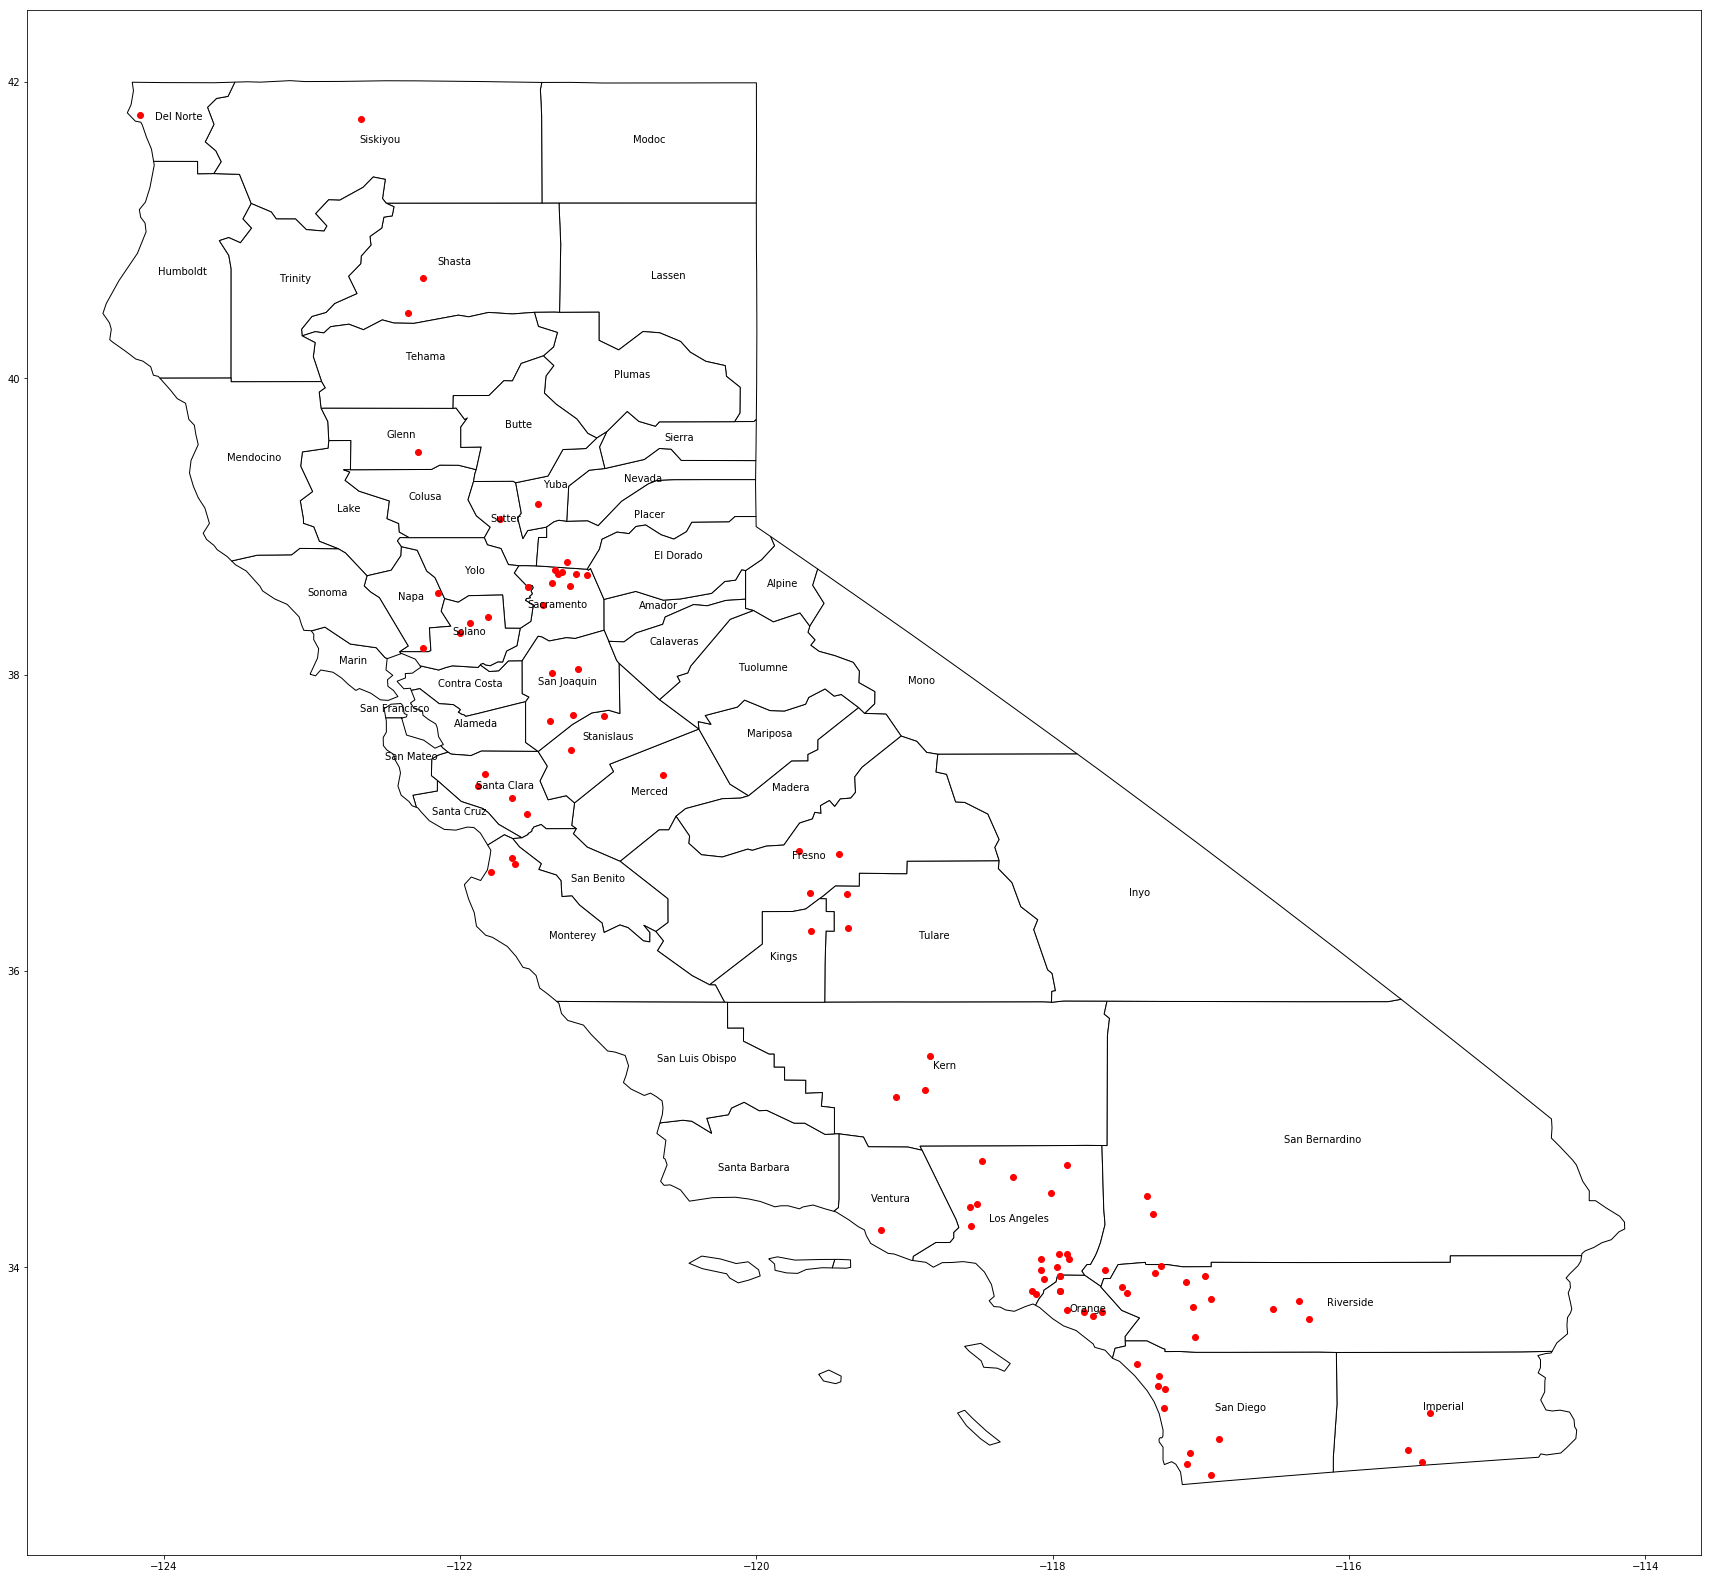

In [6]:
def combine_plot(points):
    '''Plot the latitude and longitude points on top of 
       the CA basemap. 
    
    Arguement(s):
    points -- geodataframe containing one column of POINT objects
    
    Return(s):
    finals -- matplotlib plot that contains the basemap of CA and counties along with Walmart 
              points on top
    
    '''
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 30
    fig_size[1] = 30
    plt.rcParams["figure.figsize"] = fig_size

    #06 is the CA FIPS Code
    shape_fil = gpd.read_file('CA_shapefiles/cb_2016_us_county_20m.shp')
    shape_fil = shape_fil[shape_fil['STATEFP'].str.contains('06')== True].reset_index()


    shape_fil ["x"] = shape_fil.centroid.map(lambda shape_fil: shape_fil.x)
    shape_fil ["y"] = shape_fil.centroid.map(lambda shape_fil: shape_fil.y)

    subset = shape_fil[['x', 'y']]
    tuples = [tuple(i) for i in subset.values]

    plotty = shape_fil.plot(color='white',edgecolor='black')
    #for loop plots the names of each county. 
    for i in range(len(tuples)):
        plt.annotate(s = shape_fil.NAME[i], xy=tuples[i],horizontalalignment = 'center')

    finals = points.plot(ax = plotty ,marker = "o",color = 'red')
    return finals

combine_plot(lat_lon())

From 2016 to 2017, Walmart announced to close 154 U.S stores. We are curious what factors contribute to this.

(1)	We considered the factors of location and competitors. We plotted all the remaining Walmart stores in California, and we can see that most Walmart stores are clustering in southern California (Los Angeles County, Orange County, Riverside County and San Diego County) and mid-north California (Sacramento County). We noticed that these are some big counties with many available spaces and certain amount of population. However, we can’t see any Walmart locating in Bay Area and the center of Los Angeles, where are most prosperous counties with higher average income and large population density. Walmart  faced lots of retail store competitors such as Target, which sells more superior or designer-brand home goods and Wholefood, which emphasises on organic and health products. In addition, people living in these areas have more options to shop, such as online shopping with Amazon and Google Express. 

(2)	We also considered the factor of Walmart’s marketing strategy. Walmart consistently provides customers with “Everyday Low Prices”, and their target customer group is the group of people seeking for low-price goods. In order to keep the prices low, each Walmart store has to make balances with its operation costs. In this case, some Walmart stores earn greater profits if they open in some areas with relative low rent, average salary and family income. 

(3)	also the most important reason, E-commerce becomes the main focus on wholesale retail. Walmart develops its E-commerce because it’s essential for it to consistently enhance its wholesale market. There are a few advantages Walmart can take from its E-commerce, such as low operation cost, extension of customers groups and marketplace collaboration. 

As we have analyzed why Walmart closes so many stores, we are also curious about Walmart’s online E-commerce market. We tried to figure out a series of questions like how Walmart consistently provides customer with “Everyday Low Prices” though its E-commerce market, which online departments have better performances, what kinds of benefits of Walmart’s online shoppers etc. 


In [7]:
def interactive():
    '''Plot points on a map to cluster using k-means and be able to zoom in on the clusters. 
    
    Return(s):
    maps -- An interactive plot created from folium package.
    '''
    #Make latitude and longitude points into a list of list of points.
    lats = [zipcode.isequal(i).lat for i in data_zips]
    lons = [zipcode.isequal(i).lon for i in data_zips]
    combine_list = [[lats[i]]+[lons[i]] for i in range(len(lats))]
    
    #Zoom in specfically on CA
    maps = folium.Map(location=[36.7, -119.4179], tiles='CartoDB positron', zoom_start=5)
    #Cluster points
    marker_cluster = MarkerCluster().add_to(maps)

    #Plot points
    for point in range(0, len(combine_list)):
        folium.Marker(combine_list[point],popup =data_CA['City'][point]).add_to(marker_cluster)
    return maps

interactive()

# Part 2: Walmart Products Information

In [15]:
#Top trending/popular items name
def popularity():
    ''' Using the Walmart Trending API, we extracted the top 25 bestselling items on Walmart.com
        in descending order. 
        
    Return(s): 
    df_pop -- DataFrame consisting of item name, brand name, item ID, sale prices,
              average of customer ratings, total number of reviews and how you can buy the item
              (store,online or both).
    '''
    popular = requests.get("http://api.walmartlabs.com/v1/trends",params ={"apiKey":key})
    materials = popular.json()['items']
    col_names = ['Item Name','Brand','ItemID','Sale Price','Customer Ratings'
                 ,'Number of Reviews','Offer Type','Department']
    #Item name list
    names = [materials[i]['name'] for i in range(len(materials))] 
    #Consider if the product has customer ratings/num reviews/brand name/item ID/price
    #and then either append or append 'None' for if else.
    
    #Brand name list
    brand = [materials[i]['brandName'] if 'brandName' in materials[i].keys() 
             else np.nan for i in range(len(materials))]    
    #Item IDs list
    item_IDs = [materials[i]['itemId'] if 'itemId' in materials[i].keys() 
                else np.nan for i in range(len(materials))]     
    #Sale price list
    prices = [materials[i]['salePrice'] if 'salePrice' in materials[i].keys() 
              else np.nan for i in range(len(materials))] 
    #How can item be bought list 
    off_type = [materials[i]['offerType'] if 'offerType' in materials[i].keys() 
                else np.nan for i in range(len(materials))]  
    #Customer ratings list
    cust_rates = [materials[i]['customerRating'] if 'customerRating' in materials[i].keys() 
                  else np.nan for i in range(len(materials))]
    #Number of reviews for item list
    num_reviews = [materials[i]['numReviews'] if 'numReviews' in materials[i].keys() 
                   else np.nan for i in range(len(materials))]
    #Department list
    dept = [materials[i]['categoryPath'].split('/')[0] if 'categoryPath' in materials[i].keys() 
                   else np.nan for i in range(len(materials))]
      
    df_pop = pd.DataFrame(list(zip(names,brand,item_IDs,prices
                        ,cust_rates,num_reviews,off_type,dept)), columns = col_names)
    return df_pop

popularity()

,Item Name,Brand,ItemID,Sale Price,Customer Ratings,Number of Reviews,Offer Type,Department
0,Sony PlayStation 4 Pro 1TB Star Wars Battlefro...,Sony,464936459,399.00,4.8,5.0,ONLINE_AND_STORE,Video Games
1,Microsoft Xbox One Bluetooth Wireless Controll...,Microsoft,111779721,39.00,4.572,145.0,ONLINE_AND_STORE,Video Games
2,Thor: Ragnarok (Cinematic Universe Edition) (4...,Buena Vista Home Entertainment,482746173,29.96,NaN,NaN,ONLINE_AND_STORE,Movies & TV Shows
3,"Nintendo Switch Console with Gray Joy-Con, 045...",Nintendo,55449983,299.00,4.742,124.0,ONLINE_AND_STORE,Video Games
4,"""Sceptre 32"""" Class HD (720P) LED TV (X322BV-SR)""",Sceptre,55427159,99.99,4.301,366.0,ONLINE_ONLY,Electronics
5,"Dorel Twin Over Full Metal Bunk Bed, Multiple ...",Dorel,11004672,139.00,4.429,2571.0,ONLINE_AND_STORE,Home
6,"Sony PlayStation 4 Slim 500GB Gaming Console, ...",Sony,536117094,269.00,4.0,1.0,ONLINE_AND_STORE,Video Games
7,"Mainstays Storage Cabinet, Multiple Finishes",Mainstays,20666620,59.00,3.572,1498.0,ONLINE_AND_STORE,Home
8,"Grand Theft Auto V, Rockstar Games, Xbox One, ...",Rockstar Games,41049187,29.99,4.773,97.0,ONLINE_AND_STORE,Video Games
9,"Cosco Scenera NEXT Convertible Car Seat, Otto",Cosco,41126739,34.88,4.401,1011.0,ONLINE_AND_STORE,Baby


Here are the top 25 products from Walmart's E-commerce.  We notice that most of these products are from Electronics department (7 products), following by baby (4 products) and home(3 products) departments. There are few facts from our observations:

(1)	Customers like buying TV and Tablet from the electronics department. Most of the products from electronics are online only, while most of the products from baby and home departments are both available online and instore.

(2)	 The Cell phones and Electronics departments have higher average sale price, and the home and home improvement departments have more reviews. The customer ratings are high for the Video Games and Sport & Outdoors departments. 

Some explanations might be related to Walmart’s supply chain, marketing strategy, and customers’ shopping preferences. 


In [10]:
# Sub-categories of each department.
def sub_taxonomy():
    ''' Using the Walmart Taxonomy API, we try to extract all sub-categories of each department 
        and some sub-categories of the sub-categories if it exist. 
    
    Return(s):
    df_dept -- Dataframe consisting of columns category IDs(basically department IDs),the name of the 
               sub-category, how to search for it using the search path and the department category 
               belongs to. 
    '''
    taxonomy =  requests.get("http://api.walmartlabs.com/v1/taxonomy", params = {"apiKey":key}) 
    info_col = ['Category Ids','Sub-Category','Specific Path','Department']
    ids = []            #Category Ids list
    spec_item = []      #Sub-categories for all the departments list
    paths = []          #Specific search path list
    names = []          #Department names list 
    
    #First for loop is used to get the department names and ids.
    #Second for loop is used for sub-categorie names and search path.
    #Third for loop is used only when a sub-categorie has more than one sub-sub categorie to extract
    #specific path and name.
    
    tax_j = taxonomy.json()['categories'] #Need to take out information out of nested dict. 
    
    for i in range(len(tax_j)):
        for j in range(len(tax_j[i]['children'])):
            if len(tax_j[i]['children'][j]) == 3:
                ids.append(tax_j[i]['id'])
                spec_item.append(tax_j[i]['children'][j]['name'])
                paths.append(tax_j[i]['children'][j]['path'])
                names.append(tax_j[i]['name'])
            else:
                for k in range(len(tax_j[i]['children'][j]['children'])):
                    ids.append(tax_j[i]['id'])
                    spec_item.append(tax_j[i]['children'][j]['children'][k]['name'])
                    paths.append(tax_j[i]['children'][j]['children'][k]['path'])
                    names.append(tax_j[i]['name'])
    df_dept = pd.DataFrame(list(zip(ids,spec_item,paths,names)), columns = info_col)
    return df_dept


sub_taxonomy()

,Category Ids,Sub-Category,Specific Path,Department
0,1334134,Adult Coloring Books,"Arts, Crafts & Sewing/Art & Drawing Supplies/A...","Arts, Crafts & Sewing"
1,1334134,All Art Supplies,"Arts, Crafts & Sewing/Art & Drawing Supplies/A...","Arts, Crafts & Sewing"
2,1334134,Art Tool Cleaners,"Arts, Crafts & Sewing/Art & Drawing Supplies/A...","Arts, Crafts & Sewing"
3,1334134,Art Tools,"Arts, Crafts & Sewing/Art & Drawing Supplies/A...","Arts, Crafts & Sewing"
4,1334134,Boards & Canvas,"Arts, Crafts & Sewing/Art & Drawing Supplies/B...","Arts, Crafts & Sewing"
5,1334134,Coloring Books,"Arts, Crafts & Sewing/Art & Drawing Supplies/C...","Arts, Crafts & Sewing"
6,1334134,Drawing & Illustration,"Arts, Crafts & Sewing/Art & Drawing Supplies/D...","Arts, Crafts & Sewing"
7,1334134,Drawing Tools & Accessories,"Arts, Crafts & Sewing/Art & Drawing Supplies/D...","Arts, Crafts & Sewing"
8,1334134,Painting,"Arts, Crafts & Sewing/Art & Drawing Supplies/P...","Arts, Crafts & Sewing"
9,1334134,Sketchbooks & Paper,"Arts, Crafts & Sewing/Art & Drawing Supplies/S...","Arts, Crafts & Sewing"


In [11]:
# Sub-categories of departments count
sub_taxonomy()['Department'].value_counts()

Books                      323
Clothing                   184
Baby                       149
Jewelry                    147
Home Improvement           123
Music on CD or Vinyl       119
Auto & Tires               117
Health                     115
Home                       111
Food                       110
Toys                        99
Video Games                 96
Arts, Crafts & Sewing       94
Electronics                 92
Patio & Garden              88
Pets                        82
Sports & Outdoors           71
Movies & TV Shows           70
Walmart for Business        56
Musical Instruments         56
Office                      52
Beauty                      49
Cell Phones                 47
Seasonal                    46
Party & Occasions           38
Personal Care               38
Household Essentials        34
Industrial & Scientific     25
Gifts & Registry             1
Photo Center                 1
Name: Department, dtype: int64

In [46]:
def specific(taxes): 
    ''' Using Walmart Search API,we extracted almost all products on Walmart.com from
        the Taxonomy API.
    Arguement(s):
    taxes -- dataframe containing sub-categories
    
    Return(s):
    df_specs -- Dataframe containing specific item names, the item's ID, price, rating out of 5,
                total number of reviews for product, how to buy, and which department it belongs to. 
    '''
    col_names2 = ['Item Name','ItemID','Sale Price','Customer Ratings','Number of Reviews','Offer Type','Department'
                  ,'Shipping Rate','Eligibility for 2 Day shipping','Marketplace']

    item_IDs = []
    names = []
    prices = []
    rates = []
    reviews = []
    offs = []
    ship_rate = []
    ship_2 = []
    market = []
    paths = [] 
    #First for loop extracts all the items in the sub-categories. 
    #Second for loop extracts information from EVERY item in the sub-categories. 
    for i in range(len(taxes['Category Ids'].tolist())):
        searcher = requests.get('http://api.walmartlabs.com/v1/search',params = {
            "apiKey":key,
            "query":taxes['Sub-Category'].tolist()[i],
            "categoryId":taxes['Category Ids'].tolist()[i]
        })
        
        sea_j = searcher.json() #Define a variable for .json() for convenience.
        
        if 'items' in sea_j.keys():  #Consider if there are any items under sub-category.
            for j in range(len(sea_j['items'])):
                #Consider only when the item has ratings, a set amount of reviews and know how to buy. 
                if set(('customerRating','salePrice','numReviews','offerType','itemId','standardShipRate'
                        ,'isTwoDayShippingEligible','marketplace')).issubset(sea_j['items'][j]):
                    item_IDs.append(sea_j['items'][j]['itemId'])
                    names.append(sea_j['items'][j]['name'])
                    prices.append(sea_j['items'][j]['salePrice'])
                    offs.append(sea_j['items'][j]['offerType'])
                    rates.append(sea_j['items'][j]['customerRating'])
                    reviews.append(sea_j['items'][j]['numReviews'])   
                    paths.append(sea_j['items'][j]['categoryPath'].split('/')[0])
                    market.append(sea_j['items'][j]['marketplace'])
                    ship_rate.append(sea_j['items'][j]['standardShipRate'])
                    ship_2.append(sea_j['items'][j]['isTwoDayShippingEligible'])
        else:    #Do not do anything if no items. 
            pass
    df_specs = pd.DataFrame(list(zip(names,item_IDs,prices,rates,reviews,offs
                                ,paths,ship_rate,ship_2,market)), columns = col_names2)
    return df_specs

specific(sub_taxonomy()).head(5)

,Item Name,ItemID,Sale Price,Customer Ratings,Number of Reviews,Offer Type,Department,Shipping Rate,Eligibility for 2 Day shipping,Marketplace
0,The World of Debbie Macomber: Come Home to Col...,50092278,13.56,5.0,5,ONLINE_AND_STORE,"Arts, Crafts & Sewing",5.99,True,False
1,Johanna's Christmas: A Festive Coloring Book f...,53595316,11.07,4.8,5,ONLINE_AND_STORE,Toys,5.99,True,False
2,Calm the F*ck Down: An Inappropriate and Humor...,53248591,6.99,5.0,4,ONLINE_ONLY,"Arts, Crafts & Sewing",5.99,False,False
3,Country Scenes Adult Coloring Book,33940493,5.99,4.55,20,ONLINE_ONLY,"Arts, Crafts & Sewing",5.99,True,False
4,Joyful Designs Artist's Adult Coloring Book,41676502,3.99,4.5,12,ONLINE_ONLY,Toys,5.99,False,False


In [35]:
# Sub-categories of departments count
tax_per=sub_taxonomy()['Department'].value_counts().to_frame().reset_index()
tax_per = tax_per.rename(columns= {'index': 'Departments'})
tax_per['percent']=tax_per.Department/(tax_per.Department.sum())
tax_per.head(5)

,Departments,Department,percent
0,Books,323,0.122674
1,Clothing,184,0.069882
2,Baby,149,0.056589
3,Jewelry,147,0.055830
4,Home Improvement,123,0.046715


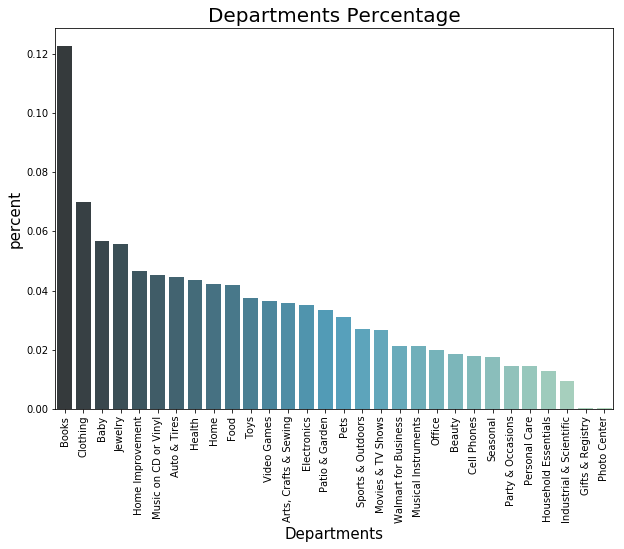

In [33]:
#Percentages of products for each department
dims = (10,7)
fig ,ax = pyplot.subplots(figsize =dims)
plt.title('Departments Percentage')
tax_per.percent.plot(kind="bar")
ax.set_xticklabels(tax_per.Departments)
ax.set_xlabel('Departments',size=15)
ax.set_ylabel('Item Percentage',size=15)
ax.set_title('Departments Percentage',size=20)
sns.barplot(x="Departments", y="percent", data=tax_per ,ax=ax, palette="GnBu_d")

In terms of number of items for each department, department of books contains the most number of items (323), which is approximately 12.27% of all items in Walmart. The top 5 departments contain the most items are: Books, Clothing, Baby, Jewelry, and Home Improvement; while the top 5 departments contain the least items are: Gifts&Registry, Photo Center, Industrial&Scientific, Household Essentials, and Personal Care. Departments with more items provide more options for customers. This could attract more customers to buy.


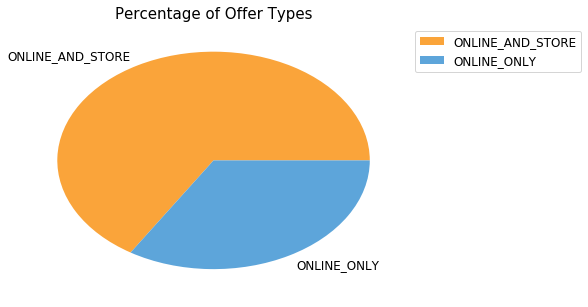

In [45]:
#Percentage of Offer Types
spec = specific(sub_taxonomy())
offer_type = spec.groupby('Offer Type').size().to_frame().reset_index()
offer_type.columns=['Offer Type','Counts']
offer_type['percent']=offer_type.Counts/(offer_type.Counts.sum())

fig ,ax = pyplot.subplots(figsize =(7,5))

matplotlib.rcParams['font.size']=12
colors = ['#FAA43A','#5DA5DA', 'purple']
plt.pie(offer_type.percent, colors=colors, labels= offer_type['Offer Type'])
plt.title('Percentage of Offer Types',size=15)
plt.legend(offer_type['Offer Type'],bbox_to_anchor=(1,1))
plt.show()

Walmart.com has 3 offer types: online and store, online only, and store only. Of all the items, 4888 items offer both online and store, which is 65.78% . There are 2542 items offer online only, which is 34.21%. From the results, we can conclude that Walmart.com is mostly targeting  online shopping and maybe try to move from in-store shopping to e-commerce. 


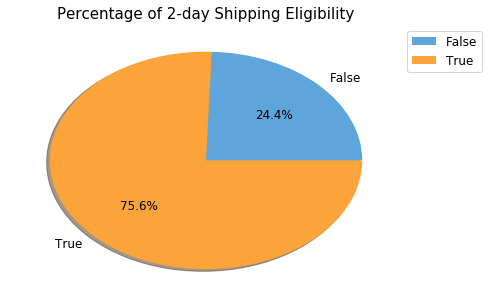

In [51]:
#Percentage of Eligibility for 2 Day shipping
normal_shipping=spec.groupby('Eligibility for 2 Day shipping').size().to_frame().reset_index()
normal_shipping.columns=['Eligibility for 2 Day shipping', 'Counts']
normal_shipping['percent']=normal_shipping.Counts/(normal_shipping.Counts.sum())

fig ,ax = pyplot.subplots(figsize =(7,5))

matplotlib.rcParams['font.size']=12
colors = ['#5DA5DA','#FAA43A']
plt.pie(normal_shipping.percent, colors=colors, shadow=True,labels= normal_shipping['Eligibility for 2 Day shipping']
        ,autopct='%1.1f%%')
plt.title('Percentage of 2-day Shipping Eligibility',size=15)
plt.legend(normal_shipping['Eligibility for 2 Day shipping'],bbox_to_anchor=(1,1))
plt.show()

The pie graph above shows that 74.7% items in Walmart.com are eligible for 2 day shipping. This means that people can get almost three-fourth of all items from Walmart’s online store in 2 days. 

In [52]:
#shipping rate, number of items, average sale price for each rate
shipping=spec.groupby('Shipping Rate').size().to_frame().reset_index()
shipping_price=spec.groupby('Shipping Rate')['Sale Price'].mean().to_frame().reset_index()
ship=pd.merge(shipping, shipping_price, on='Shipping Rate')
ship.columns=['Shipping Rate','Num_Items','Sale Price']
ship=ship.sort_values('Num_Items',ascending=False)
ship.head(2)

,Shipping Rate,Num_Items,Sale Price
1,5.99,5666,12.041975
0,0.00,1915,127.824392


The data frame shows the top 2 shipping rates of Walmart.com with their number of items and average sale price (these 2 categories consist of over 95% of the shipping rates). We can see that 5515 items have shipping rates `$`5.99 and average sale price `$`12.04 and 1874 items have shipping rates `$`0.00 and average sale price `$`131.29.


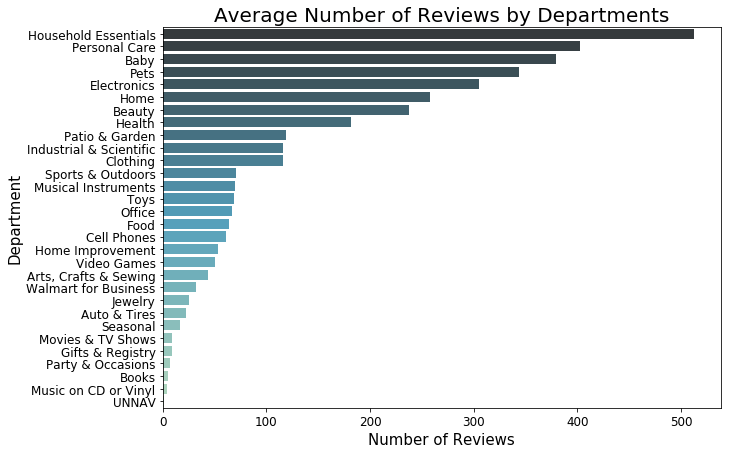

In [56]:
fig ,ax = pyplot.subplots(figsize =dims)

#average number of reviews by departments
num_reviews = spec['Number of Reviews'].groupby(spec['Department']).mean().sort_values(ascending=False).to_frame().reset_index()
num_reviews.columns=['Department','Number of Reviews']
ax.set_xlabel('Number of Reviews',size=15)
ax.set_ylabel('Department',size=15)
ax.set_title('Average Number of Reviews by Departments',size=20)
sns.barplot(x="Number of Reviews", y="Department", data=num_reviews ,ax=ax, palette="GnBu_d")

We also analyze average number of reviews of departments. Of all departments, department of household essentials has the most average number of reviews, which is 503.96 reviews while UNNAV only contains an average of 3.5 reviews. 

4.277791616116719

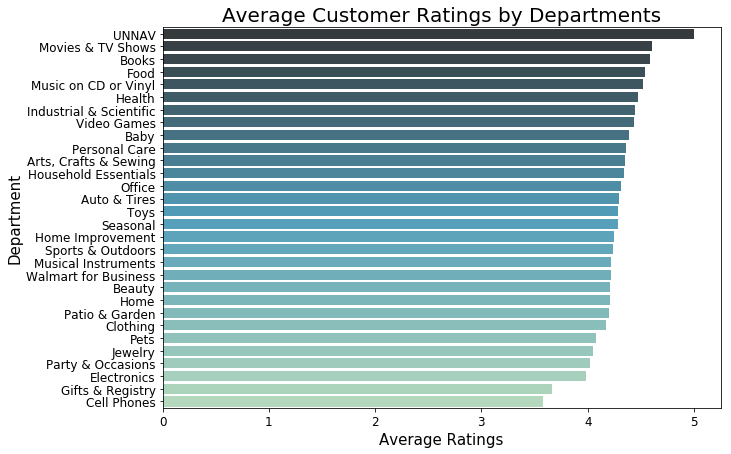

In [57]:
fig ,ax = pyplot.subplots(figsize =dims)

#average customer ratings by departments
cus_rate = spec['Customer Ratings'].astype(float).groupby(spec['Department']).mean().sort_values(ascending=False).to_frame().reset_index()
cus_rate.columns=['Department','Average Ratings']
ax.set_xlabel('Average Ratings',size=15)
ax.set_ylabel('Department',size=15)
ax.set_title('Average Customer Ratings by Departments',size=20)
sns.barplot(x="Average Ratings", y="Department", data=cus_rate,ax=ax, palette="GnBu_d")
cus_rate['Average Ratings'].mean()

From the bar graph, we can see that every department have similar customer ratings. The range of all ratings is 1.027 stars with min 3.616, max 4.643 using a scale of 5. The mean value of customer ratings is 4.265.

49.74213221513258

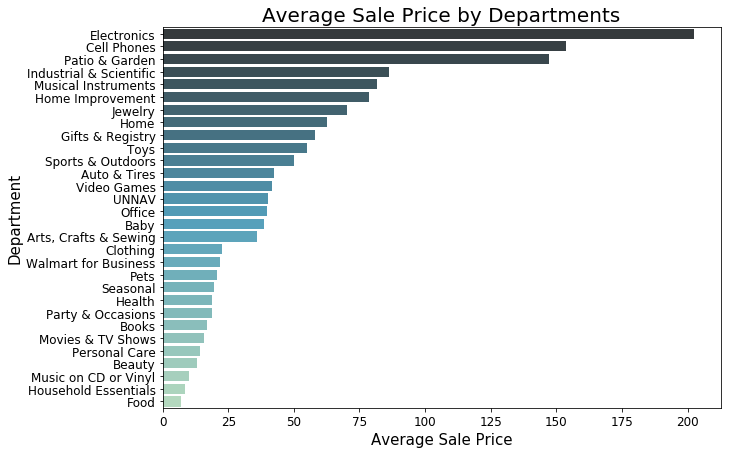

In [58]:
fig ,ax = pyplot.subplots(figsize =dims)

#Average sale price by departments
sale_price=spec['Sale Price'].astype(float).groupby(spec['Department']).mean().sort_values(ascending=False).to_frame().reset_index()
#Average sale price for overall store
#spec['Sale Price'].mean()
sale_price.columns=['Department','Average Sale Price']
ax.set_xlabel('Average Sale Price',size=15)
ax.set_ylabel('Department',size=15)
ax.set_title('Average Sale Price by Departments',size=20)
sns.barplot(x="Average Sale Price", y="Department", data=sale_price ,ax=ax, palette="GnBu_d")
sale_price['Average Sale Price'].mean()

Among all the departments, Electronics, Cell Phones, and Patio&Garden are the top 3 departments with the most average sale price; while Music on CD or Vinyl, Household Essentials and Food are the departments with the least average sale price. In addition, the average sale price of all departments in Walmart.com are less than `$`200. The average price for all items is `$`49.11.


In [14]:
#Convert to CSV. 
#specific(sub_taxonomy()).to_csv("spec.csv", index = True, sep=',', encoding='utf-8')

From the statistics above, we found something interesting:
1. Surprisingly, the average item sale price for shipping rate `$`5.99 is `$`12.04; while the average sale price for free shipping is `$`131.29, which is over ten times of the price of shipping rate `$`5.99.
2. Department of Household Essentials is one of the departments containing the least percentage of items among all items. However, this department has the most reviews.


We want to make some interpretations based on our observations:
1. In our daily lives, people are rarely willing to pay `$`5.99 for an item that only worth $12.04. As one of the biggest retail chain stores in the United States, Walmart must realize this fact. Thus, it must have some reasons behind it. We went to Walmart.com and notice that Walmart provides free 2-day shipping with minimum `$`35 orders. From the perspectives of business, this policy could promote their sales since customers will tend to buy more items in order to get the free shipping. In our case, the shipping fee could be waived when people just need to 2 more items on average. On the other hand, the average sale price of an item for free shipping is very high could be due to attraction of customers and reduction of competitions. Usually, when a customer wants to buy something over `$`100, which is expensive, he or she usually compares prices of the same item of different stores. Therefore, if the item is eligible for free shipping, the customer might be more subjective to buying the item at Walmart.

2. Since the Walmart API does not provide any information about their sales, we need to predict that from the other aspects. Number of reviews the proper approach to predict sale because people usually review an item after they buy it. The more people buy the item, the more reviews it has. From our statistics, the Household essentials has the most reviews, this means that people usually buy household essentials from Walmart.com. A plausible reason could be household essentials should have less kind of products than the other departments because most household essentials have about one or two kinds of categories of each subcategory.

# Part 3: Wordclouds per Department